In [1]:
%%html
<h2>LSTMのフィードフォワードをnumpyで実装</h2>
<ul>
  <li>sin波予測のデータをそのまま使用</li>
  <li><a href="http://deeplearning.net/tutorial/lstm.html" target="_blank">参照
　LSTM Networks for Sentiment Analysis</a> </li>
　　<li>Our modelの部分の Vo がないモデルがKerasには実装されている。</li>
</ul>

In [2]:
import pandas as pd
import math
import numpy as np

np.random.seed(0)
# 乱数の係数
random_factor = 0.05
# サイクルあたりのステップ数
steps_per_cycle = 80
# 生成するサイクル数
number_of_cycles = 50

df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles + 1), columns=["t"])
df["sin_t"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)+ np.random.uniform(-1.0, +1.0) * random_factor))

def _load_data(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.1, n_prev = 100):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))
    ntrn = int(ntrn)
    X_train, y_train = _load_data(df.iloc[0:ntrn], n_prev)
    X_test, y_test = _load_data(df.iloc[ntrn:], n_prev)

    return (X_train, y_train), (X_test, y_test)

length_of_sequences = 5
(X_train, y_train), (X_test, y_test) = train_test_split(df[["sin_t"]], n_prev =length_of_sequences) 


In [3]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM

in_out_neurons = 1
h_num = 100

model = Sequential()  
model.add(LSTM(h_num, activation="tanh", recurrent_activation="sigmoid", batch_input_shape=(None, length_of_sequences, in_out_neurons), return_sequences=False))  
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")
model.fit(X_train, y_train, batch_size=600, epochs=15, validation_split=0.05) 

y_hat_keras = model.predict(X_test)

Using TensorFlow backend.


Train on 3416 samples, validate on 180 samples
Epoch 1/15
3416/3416 [==============================] - 1s - loss: 0.4134 - val_loss: 0.2114
Epoch 2/15
3416/3416 [==============================] - 0s - loss: 0.1461 - val_loss: 0.0625
Epoch 3/15
3416/3416 [==============================] - 0s - loss: 0.0507 - val_loss: 0.0388
Epoch 4/15
3416/3416 [==============================] - 0s - loss: 0.0404 - val_loss: 0.0383
Epoch 5/15
3416/3416 [==============================] - 0s - loss: 0.0398 - val_loss: 0.0381
Epoch 6/15
3416/3416 [==============================] - 0s - loss: 0.0390 - val_loss: 0.0366
Epoch 7/15
3416/3416 [==============================] - 0s - loss: 0.0377 - val_loss: 0.0358
Epoch 8/15
3416/3416 [==============================] - 0s - loss: 0.0366 - val_loss: 0.0351
Epoch 9/15
3416/3416 [==============================] - 0s - loss: 0.0355 - val_loss: 0.0330
Epoch 10/15
3416/3416 [==============================] - 0s - loss: 0.0330 - val_loss: 0.0312
Epoch 11/15
3416/3416 

In [4]:
weights = model.get_weights()

W, U, b, W_out, b_out = model.get_weights()

# サイクルあたりのステップ数(steps_per_cycle = 80)*サイクル(length_of_sequences=5 )
print("W.shape : ", W.shape)

print("U.shape : ", U.shape)
print("b.shape : ", b.shape)
print("W_out.shape : ", W_out.shape)
print("b_out.shape : ", b_out.shape)

Wi = W[:,0:h_num]
Wf = W[:,h_num:2*h_num]
Wc = W[:,2*h_num:3*h_num]
Wo = W[:,3*h_num:]

print("Wi : ",Wi.shape)
print("Wf : ",Wf.shape)
print("Wc : ",Wc.shape)
print("Wo : ",Wo.shape)

Ui = U[:,0:h_num]
Uf = U[:,h_num:2*h_num]
Uc = U[:,2*h_num:3*h_num]
Uo = U[:,3*h_num:]

print("Ui : ",Ui.shape)
print("Uf : ",Uf.shape)
print("Uc : ",Uc.shape)
print("Uo : ",Uo.shape)

bi = b[0:h_num]
bf = b[h_num:2*h_num]
bc = b[2*h_num:3*h_num]
bo = b[3*h_num:]
print("bi : ",bi.shape)
print("bf : ",bf.shape)
print("bc : ",bc.shape)
print("bo : ",bo.shape)

W.shape :  (1, 400)
U.shape :  (100, 400)
b.shape :  (400,)
W_out.shape :  (100, 1)
b_out.shape :  (1,)
Wi :  (1, 100)
Wf :  (1, 100)
Wc :  (1, 100)
Wo :  (1, 100)
Ui :  (100, 100)
Uf :  (100, 100)
Uc :  (100, 100)
Uo :  (100, 100)
bi :  (100,)
bf :  (100,)
bc :  (100,)
bo :  (100,)


In [5]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

x = X_test
n = x.shape[0]

#initial
ht_1 = np.zeros(n*h_num).reshape(n,h_num) #h_{t-1}を意味する．
Ct_1 = np.zeros(n*h_num).reshape(n,h_num) ##C_{t-1}を意味する．

ht_list = []

for t in np.arange(x.shape[1]):
    xt = np.array(x[:,t,:])

    #it : t期目のinput gate 
    #  i_t = \sigma(W_{i} *x_{t} + U_{i} *h_{t-1} + b_{i})
    it = sigmoid(np.dot(xt, Wi) + np.dot(ht_1, Ui) + bi)
    # it : (390, 100)
    # xt : (390, 1), Wi : (1, 100)
    # ht_1 : (390, 100), Ui : (100, 100)
    # bi : (100,)

    # Ct_tilda : メモリーセルのt期目の候補
    #  \widetilde{C_t} = tanh(W_{c} *x_{t} + U_{c} *h_{t-1} + b_{c})
    Ct_tilda = np.tanh(np.dot(xt, Wc) + np.dot(ht_1, Uc) + bc)
    # Ct_tilda : (390, 100)
    # xt : (390, 1), Wc : (1, 100)
    # ht_1 : (390, 100), Uc : (100, 100)
    # bc : (100,)   

    # ft : t期目のforget gate
    #  f_t = \sigma(W_{f} *x_{t} + U_{f}* h_{t-1} + b_{f})
    ft = sigmoid(np.dot(xt, Wf) + np.dot(ht_1, Uf) + bf)
    # ft : (390, 100)
    # xt : (390, 1), Wf : (1, 100)
    # ht_1 : (390, 100), Uf : (100, 100)
    # bf : (100,)

    # t期目のメモリーセル
    #  C_t = i_{t} * \widetilde{C_t} + f_{t} * C_{t-1}
    Ct = it * Ct_tilda + ft * Ct_1

    # ot : t期目のoutput gate
    #  o_t = \sigma(W_{o} *x_{t} + U_{o} *h_{t-1} + V_{o} *C_{t} + b_o)
    #   V_{o}  = 0
    ot = sigmoid( np.dot(xt, Wo) + np.dot(ht_1, Uo) + bo)

    # ht : t期目のhidden layer
    #  h_t = o_{t} * tanh(C_t)
    ht = ot * np.tanh(Ct)
    ht_list.append(ht)

    ht_1 = ht
    Ct_1 = Ct

my_y_hat = np.dot(ht, W_out) + b_out

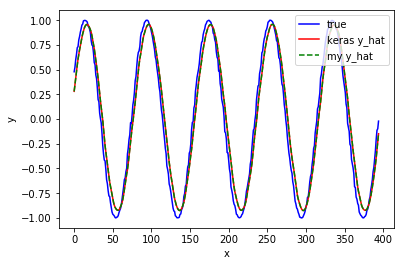

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test,label="true", color="blue")
ax.plot(y_hat_keras, label="keras y_hat", color="red")
ax.plot(my_y_hat, label="my y_hat", linestyle="dashed", color="green")
ax.legend(loc="upper right")
ax.set_ylabel("y")
ax.set_xlabel("x")
#fig.savefig("./predict1.png")
plt.show()

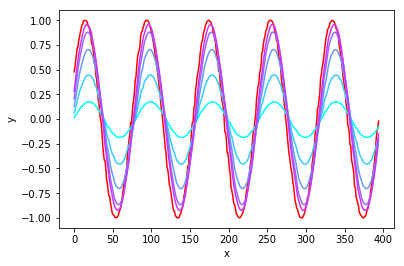

In [7]:
import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test, color="red")
for i in np.arange(len(ht_list)):
    y_hat_iter = np.dot(ht_list[i], W_out) + b_out
    ax.plot(y_hat_iter, color=cm.cool(i/len(ht_list)))

ax.set_ylabel("y")
ax.set_xlabel("x")
#fig.savefig("./predict2.png")
plt.show()
plt.close("all")